## Arrumando o Dataset

In [1]:
dataset_directory = ".\dataset"
images = []
labels = []

In [2]:
print(len(dataset_directory))

9


In [3]:
import os
import cv2

def process_images(dataset_directory):
    images = []
    labels = []
    
    for folder_name in os.listdir(dataset_directory):
        folder_path = os.path.join(dataset_directory, folder_name)
        
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            image = cv2.imread(file_path)
            
            if image is not None and not image.size == 0:
                resized_image = cv2.resize(image, (256, 256))
                images.append(resized_image)
                labels.append(folder_name)
    
    return images, labels


In [4]:
print(len(images))
print(len(labels))

724
724


## Verificando se tudo ocorreu corretamente.

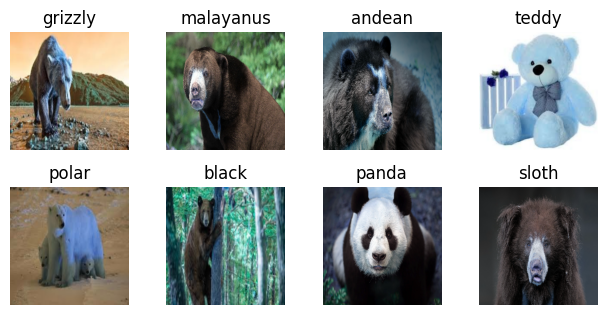

In [5]:
import numpy as np
import matplotlib.pyplot as plt

unique_labels = list(set(labels))
num_labels = len(unique_labels)
num_labels_per_line = 4
labels_array = np.array(labels)

for i, label in enumerate(unique_labels):
    index = labels_array.tolist().index(label)
    image = images[index]
    plt.subplot(num_labels // num_labels_per_line + 1, num_labels_per_line, i+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
images = np.array(images)
images = images / 255.0
labels = np.array(labels)

## Dividindo em Dados de treinamento e Validação

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 579
Testing set size: 145


## Padronizando os dados

In [13]:
X_train = X_train.reshape(len(X_train), 256, 256, 3)
X_test = X_test.reshape(len(X_test), 256, 256, 3)

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [15]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [16]:
print(y_train[0])
print(y_test[0])

[0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0.]


In [27]:
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation
from keras.initializers import he_normal
from keras.optimizers import Adam

## Criando Modelo 

In [37]:
from keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = Sequential(
    [
        base_model,
        Flatten(),
        Dense(256, activation='elu'),
        Dropout(0.2),
        Dense(8, activation='softmax')
    ]
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [23]:
'''
# Criando camadas do modelo

model = Sequential(
    [
        InputLayer(input_shape=(256, 256, 3)),
        Rescaling(1./255),

        Conv2D(32, (3, 3), padding='same', kernel_initializer=he_normal(), activation='relu'),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', kernel_initializer=he_normal(), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), padding='same', kernel_initializer=he_normal(), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', kernel_initializer=he_normal(), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), padding='same', kernel_initializer=he_normal(), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', kernel_initializer=he_normal(), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),

        Dense(256, activation='relu', kernel_initializer=he_normal()),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu', kernel_initializer=he_normal()),
        BatchNormalization(),
        Dropout(0.5),

        Dense(8, activation='softmax')
    ]
)

# Compilando modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
'''

In [38]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath = 'model.keras',
    monitor ='val_categorical_accuracy',
    verbose = True,
    save_best_only = True,
    save_weights_only=False,
    mode = 'max'
)

## Treinando de fato o modelo

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint])

## Visualizando os resultados

In [40]:
best_model_accuracy = max(history.history['categorical_accuracy'])
best_model_val_accuracy = max(history.history['val_categorical_accuracy'])

print("Training Accuracy :", best_model_accuracy)
print("Validation Accuracy :", best_model_val_accuracy)

Training Accuracy : 1.0
Validation Accuracy : 0.7724137902259827


In [42]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_test_labels, y_pred_labels)

5/5 [==============================] - 11s 2s/step


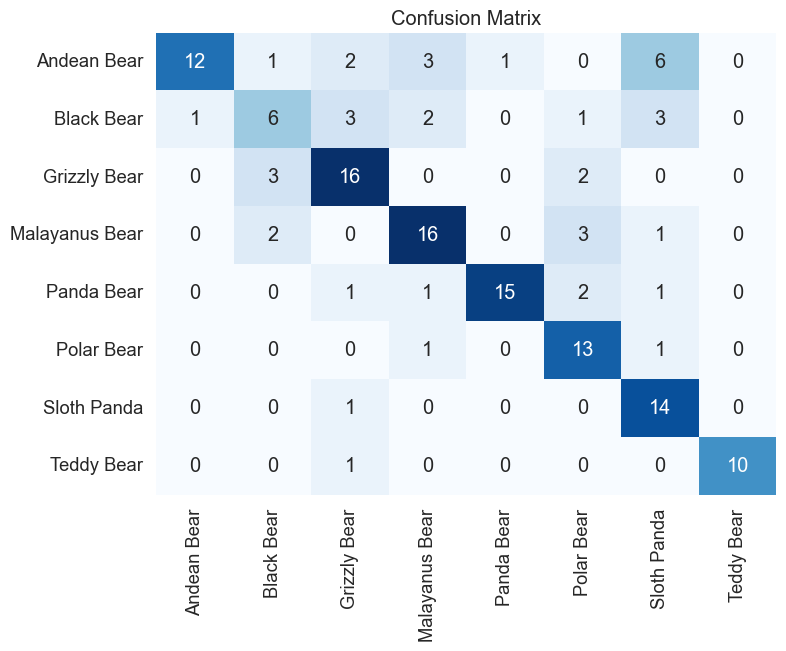

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_mtx,
    annot=True,
    cbar=False,
    fmt='d',
    cmap="Blues",
    xticklabels=['Andean Bear', 'Black Bear', 'Grizzly Bear', 'Malayanus Bear', 'Panda Bear', 'Polar Bear', 'Sloth Panda', 'Teddy Bear'],
    yticklabels=['Andean Bear', 'Black Bear', 'Grizzly Bear', 'Malayanus Bear', 'Panda Bear', 'Polar Bear', 'Sloth Panda', 'Teddy Bear'],
)

plt.title('Confusion Matrix')
plt.show()

In [48]:
from sklearn.metrics import recall_score

recall = recall_score(y_test_labels, y_pred_labels, average=None)
print("Recall:", recall)

Recall: [0.48       0.375      0.76190476 0.72727273 0.75       0.86666667
 0.93333333 0.90909091]
